In [65]:
%matplotlib inline
import time
import copy
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import gru_ode_bayes 
import gru_ode_bayes.data_utils as data_utils
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from gru_ode_bayes import Logger
import matplotlib.pyplot as plt
from scipy.sparse.csgraph import connected_components

In [144]:
file_path="D:/mimic_iii/clean_data/"
csv_file_path =file_path+"GRU_ODE_Dataset.csv"
covs_file_path=file_path+"GRU_ODE_covariates.csv"
tags_file_path=file_path+"GRU_ODE_death_tags.csv"
saps_file_path=file_path+"GRU_ODE_sapsii.csv"

In [67]:
import pickle

def pickle_dump(obj, path):
    with open(path, mode='wb') as f:
        pickle.dump(obj,f)

def pickle_load(path):
    with open(path, mode='rb') as f:
        data = pickle.load(f)
        return data

In [68]:
# ロード
d=pickle_load( file_path+'sample_unique_id_dict.pickle')


In [69]:
idx=np.array(list(d.keys()))

In [70]:
dir_path=r"D:/mimic_iii/clean_data/"
test_idx = np.load(dir_path+r"fold_idx_0/test_idx.npy")

In [140]:
test_idx

array([ 1579, 17401, 18346, ...,  5692, 17249, 17447])

## covariateの対応表を作成
(np.argmaxでcovをカテゴリ化する際に、コードがずれるのを防ぐため)

In [71]:
cov_df=pd.read_csv(covs_file_path)

In [72]:
np.argmax(cov_df.iloc[:,1:].to_numpy(), axis=1)

array([199, 199, 200, ..., 320, 190, 416], dtype=int64)

In [73]:
cov_list=list(cov_df.columns)
cov_list.pop(0)

'ID'

In [74]:
cov_dict={}
for i,cov in enumerate(cov_list):
    cov_dict[i]=cov

In [75]:
# # このdictでargmax->ICD9Code化する
# cov_dict

In [76]:
# testdataを使う場合
data_test   = data_utils.ODE_Dataset(csv_file=csv_file_path,label_file=tags_file_path,
                                    cov_file= covs_file_path, idx=test_idx, validation = False,
                                    val_options =None)

In [131]:
data_test[10]

{'idx': 10,
 'y': array([0.], dtype=float32),
 'path':     Time   Value_0   Value_1   Value_2   Value_3   Value_4   Value_5  \
 ID                                                                     
 10   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 10   2.0  0.421422  0.069531  2.181601 -0.468983 -0.518924  0.346238   
 10   9.0  0.000000  0.000000  0.000000  0.000000  0.000000 -1.492335   
 10  24.0  0.168715 -0.369888  0.418962 -0.011129 -0.518924 -0.408890   
 10  26.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 ..   ...       ...       ...       ...       ...       ...       ...   
 10  92.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 10  93.0 -0.842112  0.508950  0.308797 -0.011129 -0.657312 -0.025854   
 10  94.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 10  95.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 10  96.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000 

## sapsiiなどのために、DataLoaderとDatasetのIDの対応表を作成
ODE_Datasetの実装はIDがtext_idxに含まれている行を抽出して、pd.uniqueで前からIDを振りなおしている。それに合わせてあらかじめsapsiiスコアを抽出しておく。<br>
DataLoaderのオプションでshuffle=Falseとしているので、順番は一致する。

In [141]:
data = pd.read_csv(csv_file_path)

In [142]:
data.head()

,ID,Time,Value_0,Value_1,Value_2,Value_3,Value_4,Value_5,Value_6,Value_7,...,Mask_86,Mask_87,Mask_88,Mask_89,Mask_90,Mask_91,Mask_92,Mask_93,Mask_94,Mask_95
0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,12.0,0.000000,0.000000,0.000000,0.000000,0.242209,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,13.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,15.0,-0.336698,-0.150179,-2.224997,0.599343,0.173015,0.160192,0.0,0.786539,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,17.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [143]:
## from gru_ode_bayse data_utils.py
# self.df = self.df.loc[self.df["ID"].isin(idx)].copy() 
# map_dict= dict(zip(self.df["ID"].unique(),np.arange(self.df["ID"].nunique())))
# self.df["ID"] = self.df["ID"].map(map_dict) # Reset the ID index.
data = data.loc[data["ID"].isin(test_idx)].copy()
## dataloader id -> dataset ID
map_dict = dict(zip(np.arange(data["ID"].nunique()),data["ID"].unique()))

In [159]:
len(map_dict.keys())
map_dict[2126]

KeyError: 2126

In [78]:
dl   = DataLoader(dataset=data_test, collate_fn=data_utils.custom_collate_fn, shuffle=False, batch_size=100,num_workers=4)

In [79]:
#Model parameters.
params_dict=dict()
params_dict["hidden_size"] = 100
params_dict["p_hidden"] = 25
params_dict["prep_hidden"] = 10
params_dict["logvar"] = True
params_dict["mixing"] = 1e-4 #Weighting between KL loss and MSE loss.
params_dict["delta_t"]=0.1
params_dict["T"]= 100  #100
# lambda>0のときClassificationを行う
params_dict["lambda"] = 1 #Weighting between classification and MSE loss.
# lambda==0でないとき、validationオプションはなしにされている(validation==False)
# validationがないときは、summaryのcorrelation,validation_mse,loglik_lossは計算されず0で記録される

params_dict["classification_hidden"] = 2
params_dict["cov_hidden"] = 50
params_dict["weight_decay"] = 0.0001
params_dict["dropout_rate"] = 0
params_dict["lr"]=0.001
params_dict["full_gru_ode"] = True
params_dict["no_cov"] = False # covファイルが存在するときFalse
params_dict["impute"] = False


params_dict["input_size"]=data_test.variable_num
params_dict["cov_size"] = data_test.cov_dim

In [80]:
# model instance 生成
device = torch.device("cuda")
model = gru_ode_bayes.NNFOwithBayesianJumps(input_size = params_dict["input_size"], hidden_size = params_dict["hidden_size"],
                                            p_hidden = params_dict["p_hidden"], prep_hidden = params_dict["prep_hidden"],
                                            logvar = params_dict["logvar"], mixing = params_dict["mixing"],
                                            classification_hidden=params_dict["classification_hidden"],
                                            cov_size = params_dict["cov_size"], cov_hidden = params_dict["cov_hidden"],
                                            dropout_rate = params_dict["dropout_rate"],full_gru_ode= params_dict["full_gru_ode"], impute = params_dict["impute"])
model.to(device)

NNFOwithBayesianJumps(
  (p_model): Sequential(
    (0): Linear(in_features=100, out_features=25, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=25, out_features=192, bias=True)
  )
  (classification_model): Sequential(
    (0): Linear(in_features=100, out_features=2, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=2, out_features=1, bias=True)
  )
  (gru_c): FullGRUODECell_Autonomous(
    (lin_hh): Linear(in_features=100, out_features=100, bias=False)
    (lin_hz): Linear(in_features=100, out_features=100, bias=False)
    (lin_hr): Linear(in_features=100, out_features=100, bias=False)
  )
  (gru_obs): GRUObservationCellLogvar(
    (gru_d): GRUCell(960, 100)
    (gru_debug): GRUCell(960, 100)
  )
  (covariates_map): Sequential(
    (0): Linear(in_features=530, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=50, out_features=100, bias=True

In [81]:
# model parameter load
model_path = r'D:/mimic_iii/clean_data/trained_models/Xval_AUC_GRU_ODE_MIMIC_Binned2_NoImpute_dropout0.2_weightdecay0.0001_lambda1_fold0_MAX.pt'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [119]:
cov_latent_dict=dict()
with torch.no_grad():
    model.eval()
    for i, b in tqdm(enumerate(dl),total=len(dl)):
        times    = b["times"]
        time_ptr = b["time_ptr"]
        X        = b["X"].to(device)
        M        = b["M"].to(device)
        obs_idx  = b["obs_idx"]
        cov_np   = np.argmax(b["cov"].numpy(), axis=1)  #latent_vec取得用
        cov_np   = np.array([cov_dict[i] for i in cov_np])
        cov      = b["cov"].to(device)
        labels   = b["y"].to(device)
        batch_size = labels.size(0)
        #time_series = [[]*batch_size]
        #for j, t in enumerate(time_ptr):
            #if j==0:
            #    t0 = t
            #    continue
            #for k in obs[t0:t]:
                # time_series[k].append(j-1)
        if b["X_val"] is not None:
            X_val     = b["X_val"].to(device)
            M_val     = b["M_val"].to(device)
            times_val = b["times_val"]
            times_idx = b["index_val"]
        h0 = 0 #torch.zeros(labels.shape[0], params_dict["hidden_size"]).to(device)
        hT, loss, class_pred, t_vec, p_vec, h_vec, _, _,_,_  = model(times, time_ptr, X, M, obs_idx, delta_t=params_dict["delta_t"], T=params_dict["T"], cov=cov, return_path=True)

        sl = [0]+[134+132*i for i in range(8)]+[len(h_vec)-1]
        cov_latent_dict[i]={"cov": cov_np,"hT":hT.cpu().detach().numpy(),"h0":h_vec.cpu().detach().numpy()[0,:,:],"h_path":h_vec.cpu().detach().numpy()[sl,:,:],"y":b["y"].numpy().squeeze()}

100%|██████████| 22/22 [00:14<00:00,  1.47it/s]


In [120]:
print(cov_np)
print(len(data_test))
print(i)
print(len(b["y"]))
print(batch_size)
print(len(cov_latent_dict))
print(cov_latent_dict[0]["h0"].shape)
print(cov_latent_dict[21]["h_path"].shape)
print(hT.shape)
print(h_vec.shape)
print(class_pred.shape)

['557' '806' '198' '209' '150' '434' '038' '428' '570' '821' '823' '410'
 '038' '965' '998' '414' '323' '414' '820' '414' '197' '567' '746' '965'
 '414' '851']
2126
21
26
26
22
(100, 100)
(10, 26, 100)
torch.Size([26, 100])
torch.Size([1099, 26, 100])
torch.Size([26, 1])


In [121]:
print(times)
print(time_ptr)
print(len(time_ptr))
print(X.shape)
print(M.shape)
print(obs_idx.shape)
print(obs_idx.detach().numpy().max())

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89.
 90. 91. 92. 93. 94. 95. 96.]
[  0  26  30  32  35  38  40  45  49  56  62  68  72  79  84  90  94  99
 103 108 112 119 127 134 141 149 161 170 180 189 200 211 225 236 246 258
 269 280 289 302 314 325 334 348 359 371 380 391 403 423 434 447 457 469
 478 489 500 511 523 538 551 563 572 584 595 604 613 625 635 644 652 659
 667 677 685 698 706 717 724 735 744 751 759 765 772 777 784 789 795 801
 807 814 819 826 830 836 840 845]
98
torch.Size([845, 96])
torch.Size([845, 96])
torch.Size([845])
25


h0はICD9から出てくるので時間非依存で1時刻分はある。T=100, delta_t=0.1であるため、100timebin分の潜在変数の更新は1001回起きる（両端+終端でも評価後の値が出てくるため）。
さらにtimebinごとに値が入っていてもいなくても変数の更新は起きる。同一サンプル内で観測されている入力変数がない場合はhはそのまま、いずれかある場合はマスクはかかるが演算により変化する。
そのため、変数の更新はデータが入っている97bin(48時間・2bin/hour・両端)分だけ起きる。すべて合計するとh_pathの長さは1099となる。<br>
今回評価に欲しいのは入室時1日後の変数反映前の潜在変数であるため、時系列方向に1+48×10+1+48=530番目のh_vecを取得すればよい。同様に、6時間ごとのh_vecは1+12×10+1+12=134など、y時間後のh_vecは2+11×2×yで得られる。

In [122]:
pickle_dump(cov_latent_dict,file_path+"cov_latent_dict.pickle")

# 潜在変数を用いた分析
## ICD-9ごとに死亡率・潜在変数の平均を取って可視化

In [123]:
cov_latent_dict=pickle_load(file_path+"cov_latent_dict.pickle")

In [124]:
h0=cov_latent_dict[0]['h0']
h_path=cov_latent_dict[0]['h_path']
hT=cov_latent_dict[0]["hT"]
cov=cov_latent_dict[0]['cov']
y=cov_latent_dict[0]['y']
for i in range(list(cov_latent_dict.keys())[-1]):
    h0=np.vstack([h0,cov_latent_dict[i+1]['h0']])
    h_path=np.concatenate([h_path,cov_latent_dict[i+1]['h_path']],axis=1)
    hT=np.vstack([hT,cov_latent_dict[i+1]["hT"]])
    cov=np.append(cov,cov_latent_dict[i+1]['cov'])
    y=np.append(y,cov_latent_dict[i+1]['y'])
h1 = h_path[3,:,:]

In [125]:
print(h_path.shape)
print(h1.shape)

(10, 2126, 100)
(2126, 100)


In [114]:
print(h0.shape)
print(h1.shape)
print(hT.shape)

(2126, 100)
(2126, 100)
(2126, 100)


In [29]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#h0=scaler.fit_transform(h0)
#h1=scaler.fit_transform(h1)
#hT=scaler.fit_transform(hT)

In [30]:
# from sklearn.manifold import TSNE
# tsne=TSNE(n_components=2, random_state=1)
# h0_2dim=tsne.fit_transform(h0)
# hT_2dim=tsne.fit_transform(hT)

In [117]:
# umapのほうがかなり高速なのでtsne->umap
import umap
umap_obj=umap.UMAP(random_state=0, n_neighbors=5)
h0_2dim=umap_obj.fit_transform(h0)
h1_2dim=umap_obj.fit_transform(h1)
hT_2dim=umap_obj.fit_transform(hT)
h_path_2dim = [umap_obj.fit_transform(i) for i in h_path]

### ICD-9ごとの死亡率

In [54]:
df_0=pd.DataFrame([cov,y,h0_2dim[:,0],h0_2dim[:,1]]).T
df_0.columns=["cov","y","h0_x","h0_y"]
df_0.head()

,cov,y,h0_x,h0_y
0,414,0,-6.89337,15.2932
1,814,0,12.85,5.76073
2,431,1,-5.14902,-18.0953
3,952,0,4.10618,-1.13383
4,861,0,1.67362,-10.16


In [55]:
df_0["y"]=df_0["y"].astype(float)
df_0["h0_x"]=df_0["h0_x"].astype(float)
df_0["h0_y"]=df_0["h0_y"].astype(float)
h0_stat=df_0.groupby("cov").mean()

Text(0.5, 1.0, 'Mortality')

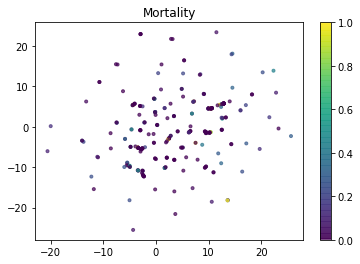

In [56]:
plt.scatter(h0_stat["h0_x"],h0_stat["h0_y"],c=h0_stat["y"],alpha=0.7,marker=".")
plt.colorbar()
plt.title("Mortality")

### hTでの病種別重心と死亡率

In [57]:
df_T=pd.DataFrame([cov,y,hT_2dim[:,0],hT_2dim[:,1]]).T
df_T.columns=["cov","y","hT_x","hT_y"]
df_T.head()

,cov,y,hT_x,hT_y
0,414,0,11.7391,11.0332
1,814,0,6.50944,4.04828
2,431,1,7.80985,6.79935
3,952,0,12.4647,5.52934
4,861,0,10.5779,12.0156


In [58]:
df_T["y"]=df_T["y"].astype(float)
df_T["hT_x"]=df_T["hT_x"].astype(float)
df_T["hT_y"]=df_T["hT_y"].astype(float)
hT_stat=df_T.groupby("cov").mean()

Text(0.5, 1.0, 'Mortality')

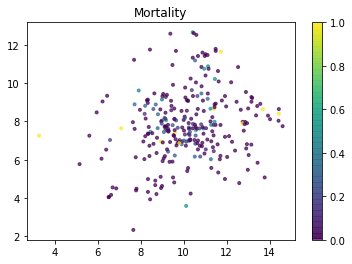

In [59]:
#hT_stat.iloc[:,1:3]=scaler.fit_transform(hT_stat.iloc[:,1:3])
plt.scatter(hT_stat["hT_x"],hT_stat["hT_y"],c=hT_stat["y"],alpha=0.7,marker=".")
plt.colorbar()
plt.title("Mortality")

### h1(24hour after from first record)での病種別重心と死亡率

In [60]:
df_1=pd.DataFrame([cov,y,h1_2dim[:,0],h1_2dim[:,1]]).T
df_1.columns=["cov","y","h1_x","h1_y"]
df_1["y"]=df_1["y"].astype(float)
df_1["h1_x"]=df_1["h1_x"].astype(float)
df_1["h1_y"]=df_1["h1_y"].astype(float)
h1_stat=df_1.groupby("cov").mean()

Text(0.5, 1.0, 'Mortality')

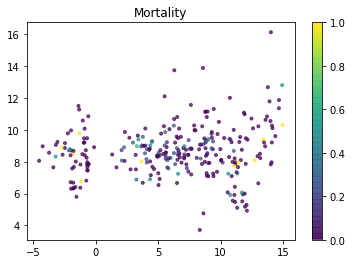

In [61]:
#h1_stat.iloc[:,1:3]=scaler.fit_transform(h1_stat.iloc[:,1:3])
#plt.scatter(hT_stat["hT_x"],hT_stat["hT_y"],c=hT_stat["y"],cmap='OrRd',alpha=0.7)
plt.scatter(h1_stat["h1_x"],h1_stat["h1_y"],c=h1_stat["y"],alpha=0.7,marker=".")
plt.colorbar()
plt.title("Mortality")

## 個別データの利用
### hTでの全点表示
これを使って死亡予測をしているので、当然ある程度は傾向が見えるはず。

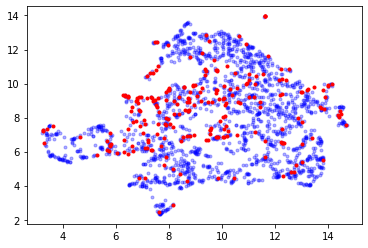

In [62]:
c=["blue","red"]
alpha=[0.3,1]
s=[10,5]
for i in range(2):
    plt.scatter(df_T[df_T["y"]==i]["hT_x"],df_T[df_T["y"]==i]["hT_y"],marker=".",color=c[i],alpha=alpha[i])


### h1での全点表示
途中の傾向を見ていることに大きな傾向が見えるか。

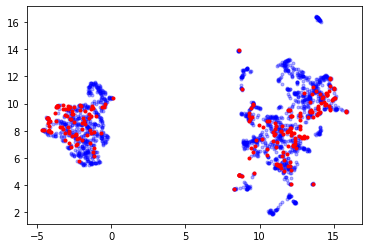

In [63]:
c=["blue","red"]
alpha=[0.3,1]
s=[10,5]
for i in range(2):
    plt.scatter(df_1[df_1["y"]==i]["h1_x"],df_1[df_1["y"]==i]["h1_y"],marker=".",color=c[i],alpha=alpha[i])


### h0での全点表示
事前情報として与えられたICD-9コードがモデルにより変換されたものに相当する

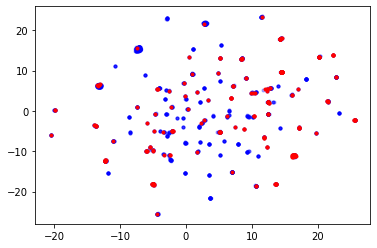

In [64]:
c=["blue","red"]
alpha=[0.3,1]
s=[10,5]
for i in range(2):
    plt.scatter(df_0[df_0["y"]==i]["h0_x"],df_0[df_0["y"]==i]["h0_y"],marker=".",color=c[i],alpha=alpha[i])


## 分散の遷移をみる
ICD-9ごとにまとめた分散はどのように変化するのか
生存、死亡についてはどうか。

## sapsiiスコアとの連携
ひとまず可視化から

In [149]:
saps = pd.read_csv(saps_file_path)
saps = saps.loc[saps["ID"].isin(test_idx)].copy()
saps.head()

,ID,UNIQUE_ID,sapsii,sapsii_prob,age_score,hr_score,sysbp_score,temp_score,pao2fio2_score,uo_score,...,potassium_score,sodium_score,bicarbonate_score,bilirubin_score,gcs_score,comorbidity_score,admissiontype_score,SUM_score,X,PROB
2,16859,15179,43,0.305597,18,2.0,5.0,0.0,6.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0,8,17.0,-3.628210,0.974124
5,7440,16853,39,0.229592,12,2.0,5.0,0.0,11.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0,6,21.0,-3.133322,0.958246
12,11700,20359,51,0.483852,16,4.0,13.0,0.0,6.0,0.0,...,0.0,0.0,0.0,NaN,0.0,0,6,29.0,-2.234466,0.903302
41,7109,4540,23,0.052195,0,0.0,5.0,0.0,6.0,0.0,...,3.0,1.0,0.0,NaN,0.0,0,8,15.0,-3.893052,0.980024
42,7950,11017,15,0.019976,7,0.0,5.0,0.0,NaN,0.0,...,3.0,0.0,0.0,NaN,0.0,0,0,8.0,-4.982647,0.993191


In [164]:
len(test_idx)

2127

In [185]:
## dataloader id -> dataset ID
#map_dict = dict(zip(np.arange(data["ID"].nunique()),data["ID"].unique()))
saps_score = pd.DataFrame({"ID":[i for i in range(len(map_dict.keys()))],
                            "sapsii_score":[saps[saps["ID"]==map_dict[i]]["sapsii"].values  for i in range(len(map_dict.keys()))]})
saps_score["sapsii_score"] = 
saps_score.head()

,ID,sapsii_score
0,0,[69]
1,1,[49]
2,2,[39]
3,3,[51]
4,4,[44]


In [199]:
np.where(np.array([len(i) for i in saps_score["sapsii_score"]])==0)
np.where(np.array([len(i) for i in saps_score["sapsii_score"]])>1)

(array([   8,   73,   88,  118,  156,  181,  192,  193,  204,  209,  218,
         252,  254,  270,  296,  318,  392,  397,  399,  404,  412,  443,
         488,  489,  497,  505,  521,  550,  562,  571,  572,  580,  581,
         592,  604,  626,  630,  634,  653,  672,  677,  685,  687,  698,
         711,  740,  762,  765,  785,  796,  797,  800,  806,  825,  846,
         848,  864,  872,  899,  901,  904,  932,  933,  946,  947,  982,
        1008, 1080, 1088, 1097, 1100, 1103, 1111, 1123, 1129, 1148, 1154,
        1155, 1162, 1178, 1188, 1223, 1256, 1262, 1268, 1300, 1309, 1330,
        1334, 1339, 1340, 1349, 1355, 1368, 1409, 1410, 1442, 1456, 1475,
        1479, 1505, 1539, 1544, 1556, 1565, 1588, 1645, 1666, 1677, 1685,
        1691, 1723, 1743, 1747, 1763, 1783, 1792, 1795, 1815, 1830, 1851,
        1874, 1895, 1903, 1909, 1912, 1943, 1977, 1979, 2005, 2017, 2019,
        2028, 2044, 2045, 2063, 2082, 2113, 2125], dtype=int64),)

In [ ]:
saps_score = 

## 病種を大分類に

In [57]:
# ICD9をshortcodeからさらに大分類に分ける a-rまで
def classifyICD(code):
    if code.isdecimal():
        code=int(code)
        if code <=139:
            return "a" #infectious and parasitic diseases
        elif code<=239:
            return "b" #neoplasms
        elif code<=279:
            return "c" #endocrine, nutritional and metabolic diseases, and immunity disorders
        elif code<=289:
            return "d" #Diseases of the Blood and Blood-forming Organs
        elif code<=319:
            return  "e"#Mental Disorders
        elif code<= 359:
            return "f"# diseases of the nervous system
        elif code<= 389:
            return  "g"#sense organs
        elif code<= 459:
            return "h"# Diseases of the Circulatory System
        elif code<= 519 :
            return  "i"# Diseases of the Respiratory System
        elif code<= 579:
            return "j"# Diseases of the Digestive System
        elif code<= 629:
            return "k"# Diseases of the Genitourinary System
        elif code<= 679:
            return  "l"# Complications of Pregnancy, Childbirth, and the Puerperium
        elif code<= 709:
            return "m"#Diseases of the Skin and Subcutaneous Tissue
        elif code<= 739:
            return  "n"# Diseases of the Musculoskeletal System and Connective Tissue
        elif code<= 759:
            return  "o"# Congenital Anomalies
        elif code<= 779:
            return  "p"#Certain Conditions originating in the Perinatal Period
        elif code<= 799:
            return  "q"#Symptoms, Signs and Ill-defined Conditions
        elif code<= 999:
            return  "r"#Injury and Poisoning
    else:
        return "others"

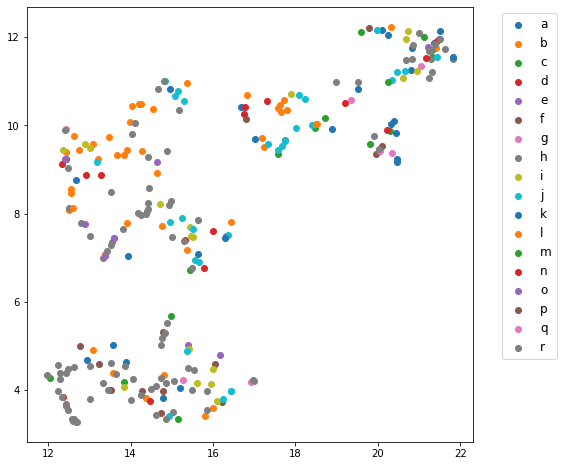

In [58]:
h0_mean=pd.concat([h0_df_agg.iloc[: ,0:2],h0_2dim_df],axis=1)
h0_mean.columns=["cov", "y","h0_x","h0_y"]
h0_mean["category"]=h0_mean["cov"].map(classifyICD)
plt.figure(figsize=(8,8))
for char in "abcdefghijklmnopqr":
    plt.scatter(h0_mean[h0_mean["category"]==char]["h0_x"],h0_mean[h0_mean["category"]==char]["h0_y"],label=char)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=12)

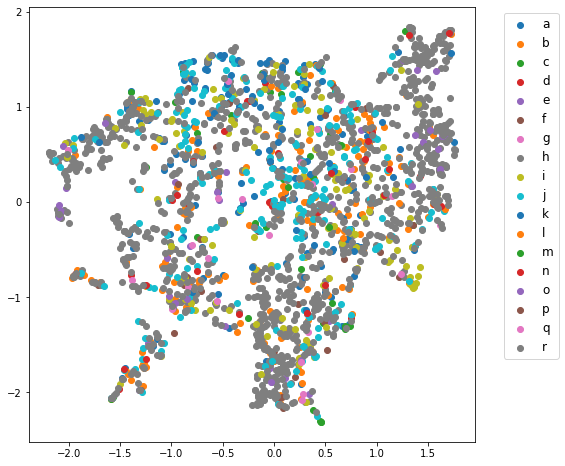

In [59]:
df_hT=copy.deepcopy(df)
df_hT["category"]=df_hT["cov"].map(classifyICD)
df_hT.head()
plt.figure(figsize=(8,8))
for char in "abcdefghijklmnopqr":
    plt.scatter(df_hT[df_hT["category"]==char]["hT_x"],df_hT[df_hT["category"]==char]["hT_y"],label=char)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=12)

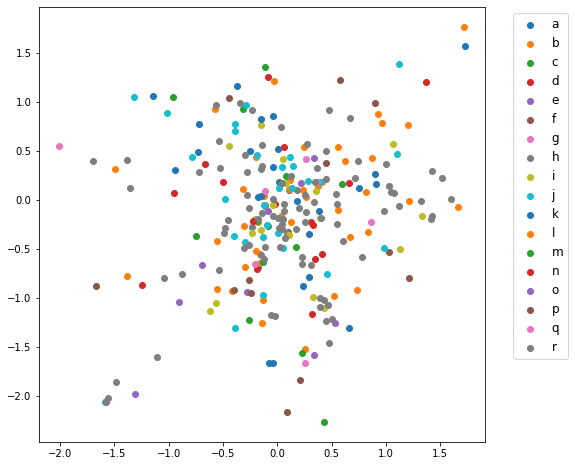

In [60]:
df_hT=copy.deepcopy(df)
df_hT=df_hT.groupby("cov").mean().reset_index()
df_hT["category"]=df_hT["cov"].map(classifyICD)
plt.figure(figsize=(8,8))
for char in "abcdefghijklmnopqr":
    plt.scatter(df_hT[df_hT["category"]==char]["hT_x"],df_hT[df_hT["category"]==char]["hT_y"],label=char)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=12)

## UMAP

In [ ]:
def draw_umap(data,label ,n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);
    fig = plt.figure(figsize=(8,8))
    cmap="cool"
    if n_components == 1:
#         ax = fig.add_subplot(111)
        plt.scatter(u[:,0], range(len(u)), c=label,cmap=cmap)
        plt.colorbar()
    if n_components == 2:
#         ax = fig.add_subplot(111)
        plt.scatter(u[:,0], u[:,1],c=label,cmap=cmap)
        plt.colorbar()
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], c=label, s=100,cmap=cmap)


    plt.title(title, fontsize=18)

In [ ]:
draw_umap(h0,h0_mean["y"],min_dist=0.2,n_components=3, title='n_components = 3')